Notebook for predicting the non-normalized features between EEG and dimensionally reduced ECoG.
EEG and ECoG have undergone CRA before hand

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install numpy matplotlib scipy numba scikit-learn mne PyWavelets pandas mne-features torch torchvision torchviz

In [4]:
import torch
from torch.autograd import Variable
import torch.nn.utils.rnn as pad
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import statistics
from torch import nn 
import random
import matplotlib.pyplot as plt
import os

In [5]:
#@title General File Methods

def directory_creation(base, addition):
  lwr_dir = os.path.join(base,addition)
  if not os.path.exists(lwr_dir):
    os.makedirs(lwr_dir)
  return lwr_dir

In [6]:
#@title Autoencoder Class
#class definition of model
class Encoder(torch.nn.Module):
  def __init__(self,input_size, bottleneck_size):
    super(Encoder,self).__init__()
    self.linear_list = torch.nn.ModuleList()
    self.activation_function = torch.nn.ModuleList()
    shift_len = 0

    #expect the shiftlen to be the pwr of 2 higher than input_size (ex. 129 should be 256)
    while (input_size >> shift_len) > 0:
      shift_len += 1
    shift_len -=2 # go from 64
    output_size = 1 << shift_len
    while output_size >= bottleneck_size:
      print(f"Encoder: Created Linear=({input_size,output_size})")
      self.linear_list.append(torch.nn.Linear(input_size,output_size))
      self.activation_function.append(torch.nn.Tanh()) #restricts the output(including from last layer) to be between -1 to 1
      input_size = output_size
      output_size >>= 1
    assert len(self.activation_function) == len(self.linear_list)

  def forward(self,X):
    reduced_data = X
    for i in range(len(self.activation_function)):
      reduced_data = self.linear_list[i](reduced_data)
      reduced_data = self.activation_function[i](reduced_data)
    return reduced_data

class Decoder(torch.nn.Module):
  def __init__(self,input_size, output_size):
    super(Decoder,self).__init__()
    self.linear_list = torch.nn.ModuleList()
    self.activation_function = torch.nn.ModuleList()
    shift_len = 0 

    while (input_size << 1) < 128 : 
      print(f"Decoder: Created Linear=({input_size,input_size << 1})")
      self.linear_list.append(torch.nn.Linear(input_size,input_size << 1))
      self.activation_function.append(torch.nn.Tanh())
      input_size = input_size << 1
    
    print(f"Decoder: Created Linear=({input_size,output_size})")
    self.linear_list.append(torch.nn.Linear(input_size,output_size))
    self.activation_function.append(torch.nn.Tanh())
    assert len(self.activation_function) == len(self.linear_list)
  def forward(self, X):
    encoded_data = X
    for i in range(len(self.activation_function)):
      encoded_data = self.linear_list[i](encoded_data)
      encoded_data = self.activation_function[i](encoded_data)
    return encoded_data

#expect auto-encoder to accept normalized(CRA_Sig(Y)) + dimensionally reduce
#normalized(CRA_Sig(Y)) => normalized(CRA_Sig(Y))_hat
class Autoencoder(torch.nn.Module):
  def __init__(self,input_size, bottleneck):
    super(Autoencoder,self).__init__()
    self.encoder = Encoder(input_size,bottleneck)
    self.decoder = Decoder(bottleneck,input_size)

  def forward(self,X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded


    
#how we obtain the PCA/demapped results of the ECoG; only used after full training is done
@torch.no_grad()
def get_latent_space(model, X):
  return model.encoder(X)

@torch.no_grad()
def decode_latent(model, Y):
  return model.decoder(Y)

def create_Autoencoder(autoencoder_loc):
  autoencoder_model = Autoencoder(129,16)
  autoencoder_model.load_state_dict(torch.load(autoencoder_loc))
  autoencoder_model.eval()
  return autoencoder_model

In [7]:
def repack_hidden_states(hidden,cell,mode = "data"):
  #for BPTT- do not want to calculate gradient by going all the way back to the first time step
  #proposed by https://github.com/pytorch/examples/blob/main/word_language_model/main.py
  if mode in "detach":
    return  hidden.detach(), cell.detach()
  #proposed by https://github.com/wcneill/jn-ml-textbook/blob/master/Deep%20Learning/04%20Recurrent%20Networks/pytorch13b_LSTM.ipynb
  elif mode in "data":
    return hidden.data, cell.data
  elif mode in "detach2":
    return hidden.clone().detach(), cell.clone().detach()

In [8]:
#@title Model Class: General, EEG to ECoG Model
def normalize_tensor2(range_val,tensor, batch_id):
  mins = torch.min(tensor,dim=1,keepdim=True)
  maxes = torch.max(tensor,dim=1,keepdim=True)
  tensor -= mins[0]
  tensor /= (maxes[0] - mins[0])
  return tensor * (range_val[1]- range_val[0]) + range_val[0]

class Pack_Padded_Model(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,batch_size, range_val,dropout_prob=0.05):
    super(Pack_Padded_Model,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size
    self.dropout_prob = dropout_prob
    self.num_layer = 1
    self.range_val = range_val

    self.lstm1 = torch.nn.LSTM(self.input_size,self.hidden_size, batch_first = True)
    self.lstm2 = torch.nn.LSTM(self.hidden_size,self.hidden_size, batch_first = True)
    self.hidden_linear = torch.nn.Linear(self.hidden_size * 2, self.output_size)

  def forward(self,input, prev_estimate, hidden_inp, cell_inp, hidden_seq, cell_seq, batch_ind, skip_optim):
    output, (hidden_inp,cell_inp) = self.lstm1(input,(hidden_inp,cell_inp)) #input a packedsequence
    estimate_i, (hidden_seq,cell_seq) = self.lstm2(prev_estimate,(hidden_seq,cell_seq)) #input a unpacked,padded estimate batch(initially all pad)
    #unpack and unpad packed output
    combined = torch.cat((output.data,estimate_i.data),dim=2)
    if skip_optim == False:
      combined.requires_grad = True
      assert output.requires_grad == True and estimate_i.requires_grad == True and combined.requires_grad == True
    unpacked_output = self.hidden_linear(combined)
    # #renormalize data to fit specified range in normalization
    # if torch.min(unpacked_output).item() < self.range_val[0]:
    #   print('.',end='')
    #   unpacked_output = normalize_tensor2(self.range_val,unpacked_output,batch_ind)
    # elif torch.max(unpacked_output).item() > self.range_val[1]: 
    #   print('!',end='')
      # unpacked_output = normalize_tensor2(self.range_val,unpacked_output,batch_ind)
    
    # return hidden states so can continue with prev for the next batch
    hidden_inp, cell_inp = repack_hidden_states(hidden_inp, cell_inp)
    hidden_seq, cell_seq = repack_hidden_states(hidden_seq, cell_seq)
    return unpacked_output, hidden_inp, cell_inp, hidden_seq, cell_seq

In [9]:
#@title Training Loss Curve
def plot_loss(model_loss,epoch_id, model_type, error_type,range_key,img_dir):
  assert len(model_loss) == 2
  print(f'Plotting {model_type}_{epoch_id} {error_type} Loss....')
  x_vals = list(range(0,len(model_loss[0])))
  subdir = directory_creation(img_dir,"Loss")
  plot_error(x_vals,model_loss,epoch_id,model_type,error_type,range_key,subdir)

def plot_error(x_vals, y_vals, epoch_i, model_type, error_type, range_key,images_dir):
  plt.figure(figsize=(10,10))
  counter = 0
  dataset_type = ["train","validation","test"]
  colors = ['r','b','y']
  style = ['-','--','.']
  for y_coors in y_vals:
    assert len(y_coors) == len(x_vals)
    plt.plot(x_vals,y_coors,colors[counter]+style[counter], label=dataset_type[counter])
    counter += 1
  plt.title(f'LSTM-NARX {model_type} Loss Curves until Epoch {epoch_i}')
  plt.xlabel('Epoch (#)')
  plt.ylabel(f'Error ({error_type})')
  plt.legend(loc='best')
  plt.savefig(f"{images_dir}/{error_type}_{range_key}_curve_{epoch_i}_{model_type}.png")
  plt.show()

In [10]:
#@title Plotting Original Vs Estimate Predictions
"""
responsible for plotting original vs estimate
"""
def plot_estimates(window_size,estimates, real, model_type, norm_type, range_key, img_dir):
  assert len(estimates) == len(real)
  assert estimates[0].shape[0:2] == real[0].shape[0:2] and estimates[-1].shape[0:2] == real[-1].shape[0:2]
  sequence = random.randint(0,estimates[0].size(0)-1) # choose one of the sequences
  random_window_start = random.randint(0,len(estimates)-window_size) # choose a starting batch index for window

  final_estimate = torch.cat(estimates[random_window_start:random_window_start+window_size],dim=1)[sequence]
  rand_channel = random.randint(0,real[0].shape[2]-1)


  final_estimate = torch.transpose(final_estimate.data.float(),0,1)[rand_channel].numpy()
  final_real = torch.transpose(torch.cat(real[random_window_start:random_window_start+window_size],dim=1)[sequence].data.float(),0,1)[rand_channel].numpy()
  x_vals = range(random_window_start * 100,random_window_start * 100 + final_estimate.shape[0])
  subdir = directory_creation(img_dir,"Estimates")
  plot_graph(x_vals,[final_real,final_estimate],model_type,norm_type,subdir,sequence,rand_channel, range_key)

colors = ['r','b','y']
style = ['-','--','.']

def plot_graph(x_vals, y_vals, model_type, norm_type, img_dir, sequence_id, rand_channel_id, range_key):
  plt.figure(figsize=(10,10))
  plt.plot(x_vals,y_vals[0],colors[0]+style[0],label="Original")
  plt.plot(x_vals,y_vals[1],colors[1]+style[1],label="Estimate")
  plt.title(f'{norm_type} ECoG {model_type}: Sequence {sequence_id}, Channel {rand_channel_id}')
  plt.xlabel('Measurement')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.savefig(f"{img_dir}/{norm_type}_estimate_{norm_type}_seq_{sequence_id}_channel{rand_channel_id}_{model_type}_{range_key}.png")
  plt.show()

In [11]:
#@title Histogram of RMSE Error
def plot_test(model_loss,model_type,error_type,range_key,img_dir, data_type):
  subdir = directory_creation(img_dir,"Loss")
  plt.figure(figsize=(10,10))
  counts, bins = np.histogram(model_loss)
  plt.hist(bins[:-1], bins, weights=counts)
  plt.title(f'Frequency of {error_type} Loss in Minibatches of {model_type}, {data_type}')
  plt.savefig(f"{subdir}/{error_type}_{range_key}_histogram_{model_type}_{data_type}.png")
  plt.show()

In [12]:
#@title Stat Table Creation

def plot_table(row_labels, col_labels, model_type, norm_type, range_key, img_dir, data):
  plt.rcParams["figure.figsize"] = [7, 4]
  plt.rcParams["figure.autolayout"] = True
  fig, axs = plt.subplots(1, 1)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=data, colLabels=col_labels, rowLabels=row_labels, loc='center')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(13)
  plt.title(f'{norm_type}\'s Predict vs. Target in {model_type}')
  lwr_dir = directory_creation(img_dir,"Stats")
  plt.savefig(f"{lwr_dir}/{norm_type}_stats_{model_type}_{range_key}.png")
  plt.show()

"""
Responsible for creating a table of statistics to display data
"""
def stats_generator(estimate_list, targ_ecog_list, feature, range_key, img_dir):
  #list = [Reduced, Normalized, Non-Normalized]
  # each term in list is another list for each feature
  test_range_type = ["PCA Normalized", "Demap Normalized", "Demap Non-Normalized"]
  stat_type = ["Mean","Standard Dev","Variance", "Data Spread"]
  data_type = ["Target","Predict"]
  for ind in range(len(estimate_list)):
    data_list = []
    data_list.append([str(round(torch.mean(targ_ecog_list[ind]).item(),3)),str(round(torch.std(targ_ecog_list[ind]).item(),3)), str(round(torch.var(targ_ecog_list[ind]).item(),3)), str((round(torch.min(targ_ecog_list[ind]).item(),3),round(torch.max(targ_ecog_list[ind]).item(),3)))])
    data_list.append([str(round(torch.mean(estimate_list[ind]).item(),3)),str(round(torch.std(estimate_list[ind]).item(),3)), str(round(torch.var(estimate_list[ind]).item(),3)), str((round(torch.min(estimate_list[ind]).item(),3),round(torch.max(estimate_list[ind]).item(),3)))])
    plot_table(data_type,stat_type,feature,test_range_type[ind],range_key,img_dir,data_list)

In [13]:
#@title Training Driver
"""
Method does one round(iterate through all minibatches in set)
Returns the total loss and estimates
"""
def one_epoch(split_eeg, split_reduced_ecog, model, cost_function, optimizer, skip_optim = True):
  
  comparison_loss = [] # obtained from comparing split_reduced_ecog and  and split_reduced_estimates

  assert len(split_eeg) == len(split_reduced_ecog) 
  assert len(split_eeg[0].shape) == len(split_reduced_ecog[0].shape) and len(split_eeg[0].shape) == 3

  #generate the hidden and cell states
  N1, Hout1, N2, Hout2 = split_eeg[0].size(0), split_reduced_ecog[0].size(2), split_reduced_ecog[0].size(0), split_reduced_ecog[0].size(2)
  assert N1 == 8 and Hout1 == 16 and N2==8 and Hout2 == 16
  hidden_1, cell_1, hidden_2, cell_2 = torch.zeros(1,N1,Hout1), torch.zeros(1,N1,Hout1), torch.zeros(1,N2,Hout2), torch.zeros(1,N2,Hout2)

  #estimate must first be 0's before doing anything
  estimate = torch.zeros(split_reduced_ecog[0].size(0),split_reduced_ecog[0].size(1), split_reduced_ecog[0].size(2))
  
  #for each 100 chunk
  for batch_ind in range(len(split_eeg)):
    #if previous step estimate is less than input's time step size, take a subset
    if estimate.shape[1] > split_eeg[batch_ind].shape[1]:
      # print(f'Taking subset of estimate due to shape mismatch:\n \tInput: {split_eeg[batch_ind].shape}Prev Step Input:{estimate.shape}')
      subset = torch.split(estimate.data,split_eeg[batch_ind].shape[1],dim=1)[0]
      if skip_optim == False:
        subset.requires_grad= True
      estimate, hidden_1,cell_1,hidden_2,cell_2 = model(split_eeg[batch_ind],subset,hidden_1, cell_1, hidden_2, cell_2,batch_ind, skip_optim)
    else:
      estimate, hidden_1,cell_1,hidden_2,cell_2 = model(split_eeg[batch_ind],estimate,hidden_1, cell_1, hidden_2, cell_2,batch_ind, skip_optim)
    
    assert estimate.shape == split_reduced_ecog[batch_ind].shape

    #get the loss and train if not skipping optim
    minibatch_loss = cost_function(estimate,split_reduced_ecog[batch_ind])
    if skip_optim == False:
      minibatch_loss.backward(retain_graph=True)
      optimizer.step()
      optimizer.zero_grad()
    comparison_loss.append(minibatch_loss.item())
    print('.',end='')
  return statistics.mean(comparison_loss)

def train_driver(epochs, inp_dataset, targ_dataset, optimizer, cost_function, model, checkpoint_dir, range_key, feature, img_dir,bookmark=15):
  train_loss = []
  val_loss = []
  print(f'Checkpoint dir = {checkpoint_dir}')
  
  inp_train_dataset = inp_dataset[0]
  inp_val_dataset = inp_dataset[1]
  targ_train_dataset = targ_dataset[0]
  targ_val_dataset = targ_dataset[1]

  print(f'Batch Gen Shape: Train={inp_train_dataset[0].shape}\tVal={inp_val_dataset[0].shape}')

  for i in range(epochs + 1):
    model.train(True)
    print(f'Training Epoch {i}',end='')
    train_loss.append(one_epoch(inp_train_dataset, targ_train_dataset, model,cost_function,optimizer,skip_optim=False))
    print(f'Avg Train Loss Epoch {i}={train_loss[-1]}')
    model.train(False)
    with torch.no_grad():
      model.eval()
      print(f'Validation Epoch {i}',end='')
      val_loss.append(one_epoch(inp_val_dataset, targ_val_dataset, model, cost_function, optimizer, skip_optim=True))
      print(f'Avg Val Loss Epoch {i}={val_loss[-1]}')
    if i > 0 and i % bookmark == 0:
      print(f'Saving LSTM_NARX_{feature} Model in {checkpoint_dir}/LSTM_NARX_{range_key}_feature_model.pt')
      torch.save(model.state_dict(),f'{checkpoint_dir}/LSTM_NARX_{range_key}_{feature}_model.pt')
      plot_loss([train_loss,val_loss],i,feature,"MSE",range_key,img_dir)
  return model

In [14]:
#@title Test Driver --Saves PCA_Normalized Estimates
def test_driver(inp_dataset, red_targ_dataset, cost_function, model, checkpoint_dir, range_key, feature,img_dir, skip_optim=True):
  if model is None:
    assert os.path.exists(f'{checkpoint_dir}/LSTM_NARX_{range_key}_{feature}_model.pt')
    if range_key[0] == '0':
      model_range = (0,1)
    else:
      model_range = (-1,1)
    print(model_range)
    model = Pack_Padded_Model(19,16,16,100,model_range)
    model.load_state_dict(torch.load(f'{checkpoint_dir}/LSTM_NARX_{range_key}_{feature}_model.pt')) #load model from file
  model.eval()
  pca_test_loss = []
  pca_estimates = []


  estimate = torch.zeros(red_targ_dataset[0].size(0),red_targ_dataset[0].size(1), red_targ_dataset[0].size(2))
  N1, Hout1, N2, Hout2 = inp_dataset[0].size(0), red_targ_dataset[0].size(2), red_targ_dataset[0].size(0), red_targ_dataset[0].size(2)
  assert N1 == 8 and Hout1 == 16 and N2==8 and Hout2 == 16
  hidden_1, cell_1, hidden_2, cell_2 = torch.zeros(1,N1,Hout1), torch.zeros(1,N1,Hout1), torch.zeros(1,N2,Hout2), torch.zeros(1,N2,Hout2)

  print(f'Testing {feature}....')
  for batch in range(len(inp_dataset)):
    if estimate.shape[1] > inp_dataset[batch].shape[1]:
      # print(f'Taking subset of estimate due to shape mismatch:\n \tInput: {split_eeg[batch_ind].shape}Prev Step Input:{estimate.shape}')
      subset = torch.split(estimate.data,inp_dataset[batch].shape[1],dim=1)[0]
      estimate, hidden_1,cell_1,hidden_2,cell_2 = model(inp_dataset[batch],subset,hidden_1, cell_1, hidden_2, cell_2,batch, skip_optim)
    else:
      estimate, hidden_1,cell_1,hidden_2,cell_2 = model(inp_dataset[batch],estimate,hidden_1, cell_1, hidden_2, cell_2,batch, skip_optim)
    pca_estimates.append(estimate.data)
    loss = cost_function(red_targ_dataset[batch],pca_estimates[-1])
    pca_test_loss.append(loss.item())

  total_estimates = torch.cat(pca_estimates,dim=1)
  assert total_estimates.shape == torch.cat(red_targ_dataset,dim=1).shape # check to see if cat properly
  print(f'Saving PCA Estimates in file {checkpoint_dir}/PCA_Normalized_{feature}_{range_key}_estimates.pt')
  torch.save(total_estimates,f'{checkpoint_dir}/PCA_Normalized_{feature}_{range_key}_estimates.pt')

  rmse_test_loss = np.sqrt(pca_test_loss)
  print(f'Avg RMSE for Normalized Principal Components, {feature}: {statistics.mean(rmse_test_loss)}')
  # plot_test(model_loss,model_type,error_type,range_key,img_dir, data_type)
  plot_test(rmse_test_loss,feature,"RMSE",range_key, img_dir, "PCA_Normalized")
  plot_estimates(2, pca_estimates, red_targ_dataset,feature, "PCA_Normalized", range_key, img_dir)

In [15]:
def prediction_sub_driver(epochs, bookmark, dataset_locations, minibatch_size,learning_rate,model_range,current_dir,feature):

  if model_range[0] == 0:
    range_key = '01'
  else:
    range_key ='11'
  assert epochs % bookmark == 0 and bookmark <= epochs

  #create dir to record results
  deeper_dir = f"LSTM_NARX_{range_key}"
  checkdir = os.path.join(current_dir,deeper_dir) #Datasets/LSTM_NARX_{}
  if not os.path.exists(checkdir):
    print(f'Created Directory {checkdir}')
    os.makedirs(checkdir)
  img_dir = os.path.join(checkdir,f"LSTM_NARX_{range_key}_{feature}_pca_normalized_loss")
  if not os.path.exists(img_dir):
    print(f'Created Directory {img_dir}')
    os.makedirs(img_dir)

  norm_eeg_locations = dataset_locations[0]
  norm_reduced_ecog_locations = dataset_locations[1]

  #train,validation,test
  assert len(norm_eeg_locations) == 3 and len(norm_reduced_ecog_locations) == 3

  prediction_model = Pack_Padded_Model(19,16,16,minibatch_size,model_range)


  norm_eeg_train, norm_reduced_ecog_train = torch.load(norm_eeg_locations[0]).float().detach(), torch.load(norm_reduced_ecog_locations[0]).float().detach()
  norm_eeg_val, norm_reduced_ecog_val = torch.load(norm_eeg_locations[1]).float().detach(), torch.load(norm_reduced_ecog_locations[1]).float().detach()
  norm_eeg_test, norm_reduced_ecog_test = torch.load(norm_eeg_locations[2]).float().detach(), torch.load(norm_reduced_ecog_locations[2]).float().detach()

  cost_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(prediction_model.parameters(),lr=learning_rate)

  assert norm_reduced_ecog_train.shape[0:2] == norm_eeg_train.shape[0:2] and norm_reduced_ecog_train.shape[2] < norm_eeg_train.shape[2]

  split_eeg = [torch.split(norm_eeg_train,minibatch_size,dim=1), torch.split(norm_eeg_val,minibatch_size,dim=1), torch.split(norm_eeg_test,minibatch_size,dim=1)]
  split_reduced_ecog = [torch.split(norm_reduced_ecog_train,minibatch_size,dim=1), torch.split(norm_reduced_ecog_val,minibatch_size,dim=1), torch.split(norm_reduced_ecog_test,minibatch_size,dim=1)]
  prediction_model = train_driver(epochs,split_eeg[0:2],split_reduced_ecog[0:2],optimizer,cost_function,prediction_model,checkdir,range_key,feature,img_dir,bookmark=bookmark)
  with torch.no_grad():
    test_driver(split_eeg[-1],split_reduced_ecog[-1],cost_function,None,checkdir,range_key,feature,img_dir)
  # test_driver(split_eeg[-1],split_reduced_ecog[-1],cost_function,prediction_model,checkdir,range_key,feature,img_dir)

In [16]:
#@title Run Test/Train of Model
def generate_dataset_locations(current_dir,range_key,feature_key, mode):
  dataset_list = []
  if type(range_key) is tuple:
    if range_key[0] == 0:
      range_key_str = '01'
    else:
      range_key_str = '11'
  else:
    assert type(range_key) is str
    range_key_str = range_key
  if "Train" in mode:
    data_types =["train","validation","test"]
    folder_prefixes = ["normalized_eeg","normalized_ecog"]
    for prefixes in folder_prefixes:
      file_list = []
      dir_loc = f"{current_dir}/checkpoint3/{prefixes}_{range_key_str}/{feature_key}_dir"
      assert os.path.exists(dir_loc)
      for data in data_types:
        if os.path.exists(f"{dir_loc}/EEG_Norm_{range_key_str}_{feature_key}_{data}.pt"):
          file_list.append(f"{dir_loc}/EEG_Norm_{range_key_str}_{feature_key}_{data}.pt")
        elif os.path.exists(f"{dir_loc}/reduced_ECoG_Norm_{range_key_str}_{feature_key}_{data}.pt"):
          file_list.append(f"{dir_loc}/reduced_ECoG_Norm_{range_key_str}_{feature_key}_{data}.pt")
      dataset_list.append(file_list)
  elif "Stats" in mode:
    folder_prefixes = [f"LSTM_NARX_{range_key_str}/PCA_Normalized","checkpoint3/normalized_ecog"]
    ecog_types = ["reduced_ECoG_Norm","ECoG_Norm"]
    for prefix in folder_prefixes:
      dir_loc = f"{current_dir}/{prefix}"
      if "LSTM" in prefix:
        dir_loc += f"_{feature_key}_{range_key_str}_estimates.pt"
        if os.path.exists(dir_loc):
          dataset_list.append(dir_loc)
        else:
          print(dir_loc + ' does not exist')
      elif "checkpoint3" in prefix:
        dir_loc += f"_{range_key_str}/{feature_key}_dir"
        for ftype in ecog_types:
          file_loc = f'{dir_loc}/{ftype}_{range_key_str}_{feature_key}_test.pt'
          if os.path.exists(dir_loc):
            dataset_list.append(file_loc)
          else:
            print(file_loc + ' does not exist')
  return dataset_list

def prediction_driver(current_dir,epochs,bookmark, range_inds, minibatch_size,learning_rate, specific_run = -1):
  torch.autograd.set_detect_anomaly(True)
  features = ["power","mean","zero","data"]
  ranges = [(0,1),(-1,1)]
  if specific_run < 0:
    for run in range(0,4):
      run_range = ranges[range_inds[run]]
      data_locations = generate_dataset_locations(current_dir,run_range,features[run],"Train")
      print(f'Obtained following data locations:\n{data_locations}')
      prediction_sub_driver(epochs,bookmark,data_locations,minibatch_size,learning_rate,run_range,current_dir,features[run])
  else:
    run_range = ranges[range_inds[specific_run]]
    data_locations = generate_dataset_locations(current_dir,run_range,features[specific_run],"Train")
    print(f'Obtained following data locations:\n{data_locations}')
    prediction_sub_driver(epochs,bookmark,data_locations,minibatch_size,learning_rate,run_range,current_dir,features[specific_run])

In [17]:
def autoencoder_enc_dec(autoencoder_model,split_ecog_tensor,function, range_key):
  trans_ecog_split = []
  for item in split_ecog_tensor:
    trans_ecog_split.append(function(autoencoder_model,item))
  res_cat = torch.cat(trans_ecog_split,dim=1)
  
  #normalize based on this
  # res_cat = normalize_tensor2(range_key,res_cat,-1).data
  return res_cat

def normalized_demapped_subdriver(estimate_file_loc, pca_file_loc, demap_normalized_file_loc, cost_function, autoencoder_model_loc, feature, range_key, img_dir,minibatch_size = 100):
  pca_estimate_tensor = torch.load(estimate_file_loc)
  split_estimate_loc = estimate_file_loc.split('/')
  split_estimate_loc[-1] = f"Demapped_{split_estimate_loc[-1]}"
  demap_estimate_loc = '/'.join(split_estimate_loc)
  pca_targ_tensor = torch.load(pca_file_loc)
  assert pca_estimate_tensor.shape == pca_targ_tensor.shape

  demap_targ_tensor = torch.load(demap_normalized_file_loc)

  split_red_estimate = torch.split(pca_estimate_tensor,minibatch_size,dim=1)
  split_demap_test = torch.split(demap_targ_tensor,minibatch_size,dim=1)

  autoencoder = create_Autoencoder(autoencoder_model_loc)
  demap_norm_res = autoencoder_enc_dec(autoencoder,split_red_estimate,decode_latent,range_key)
  demap_norm_estimates = torch.split(demap_norm_res,minibatch_size,dim=1)

  assert len(demap_norm_estimates) == len(split_demap_test)
  assert demap_norm_estimates[-1].shape == split_demap_test[-1].shape

  demap_loss = []
  for batch_id in range(len(demap_norm_estimates)):
    loss = cost_function(demap_norm_estimates[batch_id],split_demap_test[batch_id])
    demap_loss.append(loss.item())

  rmse_test_loss = np.sqrt(demap_loss)
  print(f'Avg RMSE for Demapped, Normalized {feature}: {statistics.mean(rmse_test_loss)}')
  #get the histogram loss to see distribution of errors
  plot_test(rmse_test_loss,feature,"RMSE",range_key,img_dir, "Demap Normalized")
  #compare between demapped data
  plot_estimates(2,demap_norm_estimates, split_demap_test, feature, "Demap Normalized", range_key, img_dir)
  demap_estimate_tensor = torch.cat(demap_norm_estimates,dim=1)
  print(f'Saving Demapped Estimate {demap_estimate_loc}')
  torch.save(demap_estimate_tensor,demap_estimate_loc)
  stats_generator([pca_estimate_tensor,demap_estimate_tensor],[pca_targ_tensor,demap_targ_tensor],feature,range_key,img_dir)

def normalize_demap_driver(current_dir,range_inds, minibatch_size,specific_run = -1):
  features = ["power","mean","zero","data"]
  cost_function = torch.nn.MSELoss()
  ranges = [(0,1),(-1,1)]
  if specific_run < 0:
    for run in range(0,4):
      run_range = ranges[range_inds[run]]
      if run_range[0] == 0:
        range_key = '01'
      else:
        range_key = '11'
      data_locations = generate_dataset_locations(current_dir,run_range,features[run],"Stats")
      assert len(data_locations) == 3
      model_loc = f"{current_dir}/LSTM_NARX_{range_key}/LSTM_NARX_{range_key}_{features[run]}_model.pt"
      img_dir = f"{current_dir}/LSTM_NARX_{range_key}"
      assert os.path.exists(model_loc)
      print(f'Obtained following data locations:\n{data_locations}')
      normalized_demapped_subdriver(data_locations[0], data_locations[1], data_locations[2], cost_function, model_loc, features[run], run_range, img_dir,minibatch_size=minibatch_size)
  else:
    run_range = ranges[range_inds[specific_run]]
    if run_range[0] == 0:
      range_key = '01'
    else:
      range_key = '11'
    data_locations = generate_dataset_locations(current_dir,run_range,features[specific_run],"Stats")
    print(f'Obtained following data locations:\n{data_locations}')
    model_loc = f"{current_dir}/autoencoder_{range_key}/autoencoder_{range_key}_{features[specific_run]}_model.pt"
    img_dir = f"{current_dir}/LSTM_NARX_{range_key}"
    normalized_demapped_subdriver(data_locations[0], data_locations[1], data_locations[2], cost_function, model_loc, features[specific_run], run_range, img_dir,minibatch_size=minibatch_size)


Obtained following data locations:
[['/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_eeg_01/power_dir/EEG_Norm_01_power_train.pt', '/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_eeg_01/power_dir/EEG_Norm_01_power_validation.pt', '/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_eeg_01/power_dir/EEG_Norm_01_power_test.pt'], ['/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_ecog_01/power_dir/reduced_ECoG_Norm_01_power_train.pt', '/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_ecog_01/power_dir/reduced_ECoG_Norm_01_power_validation.pt', '/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_ecog_01/power_dir/reduced_ECoG_Norm_01_power_test.pt']]
Checkpoint dir = /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01
Batch Gen Shape: Train=torch.Size([8, 100, 19])	Val=torch.Size([8, 100, 19])
Training Epoch 0................................................................

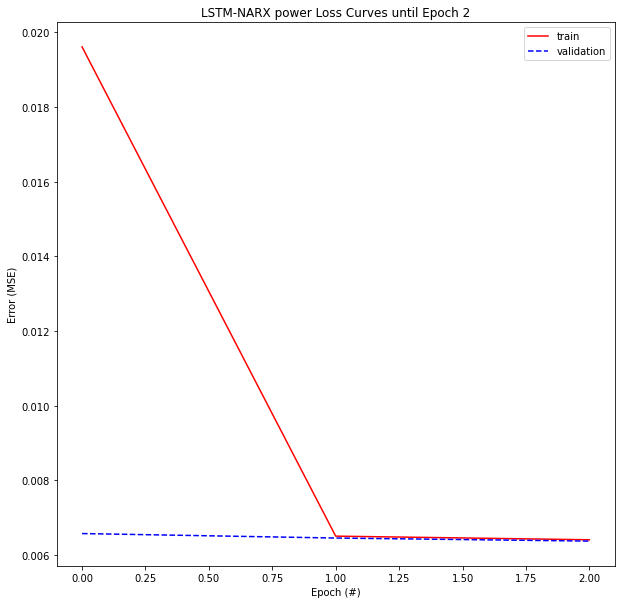

Training Epoch 3..............................................................................................................................................................................................................................Avg Train Loss Epoch 3=0.006337651823487904
Validation Epoch 3................................................................Avg Val Loss Epoch 3=0.006316925770079251
Training Epoch 4..............................................................................................................................................................................................................................Avg Train Loss Epoch 4=0.006283766801913714
Validation Epoch 4................................................................Avg Val Loss Epoch 4=0.006275307307078037
Saving LSTM_NARX_power Model in /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/LSTM_NARX_01_feature_model.pt
Plotting power_4 MSE Loss....


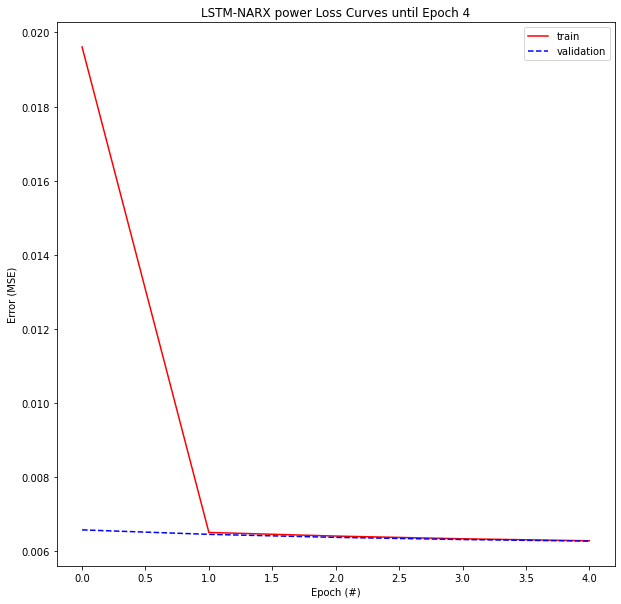

Training Epoch 5..............................................................................................................................................................................................................................Avg Train Loss Epoch 5=0.0062444435730408705
Validation Epoch 5................................................................Avg Val Loss Epoch 5=0.006245095508347731
Training Epoch 6..............................................................................................................................................................................................................................Avg Train Loss Epoch 6=0.0062151462288556605
Validation Epoch 6................................................................Avg Val Loss Epoch 6=0.0062225251604104415
Saving LSTM_NARX_power Model in /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/LSTM_NARX_01_feature_model.pt
Plotting power_6 MSE Loss....


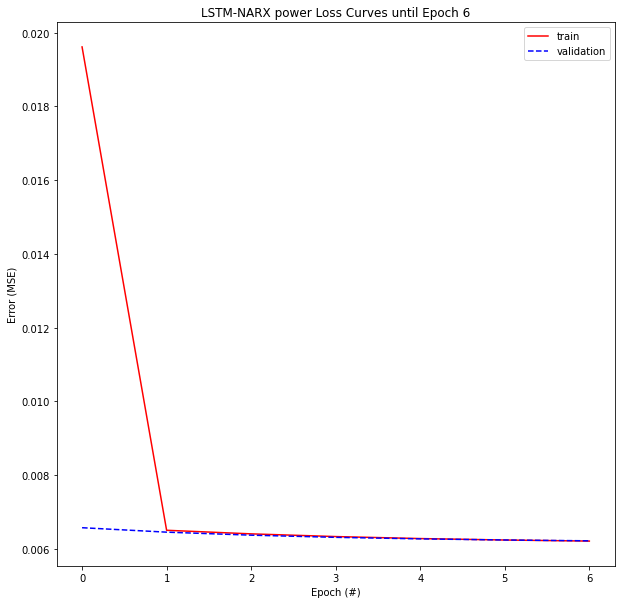

Training Epoch 7..............................................................................................................................................................................................................................Avg Train Loss Epoch 7=0.006192643849833592
Validation Epoch 7................................................................Avg Val Loss Epoch 7=0.00620542852266226
Training Epoch 8..............................................................................................................................................................................................................................Avg Train Loss Epoch 8=0.0061748841743882715
Validation Epoch 8................................................................Avg Val Loss Epoch 8=0.006192445165652316
Saving LSTM_NARX_power Model in /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/LSTM_NARX_01_feature_model.pt
Plotting power_8 MSE Loss....


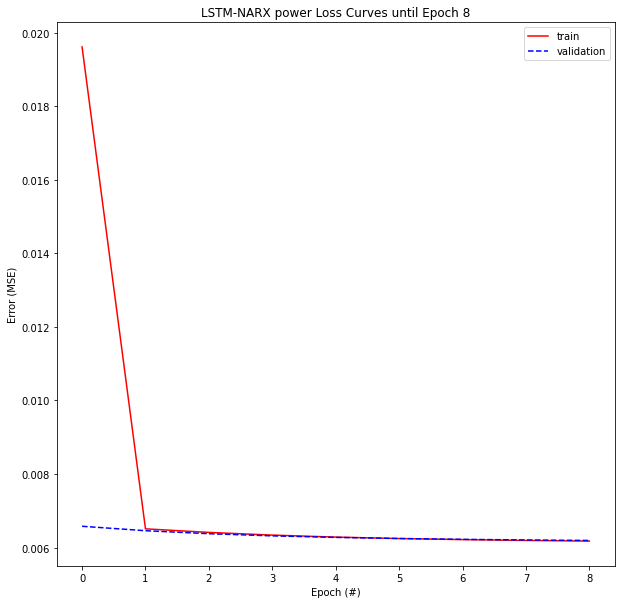

Training Epoch 9..............................................................................................................................................................................................................................Avg Train Loss Epoch 9=0.006160605925361853
Validation Epoch 9................................................................Avg Val Loss Epoch 9=0.0061825503362342715
Training Epoch 10..............................................................................................................................................................................................................................Avg Train Loss Epoch 10=0.006149017048563372
Validation Epoch 10................................................................Avg Val Loss Epoch 10=0.006174904017825611
Saving LSTM_NARX_power Model in /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/LSTM_NARX_01_feature_model.pt
Plotting power_10 MSE Loss....


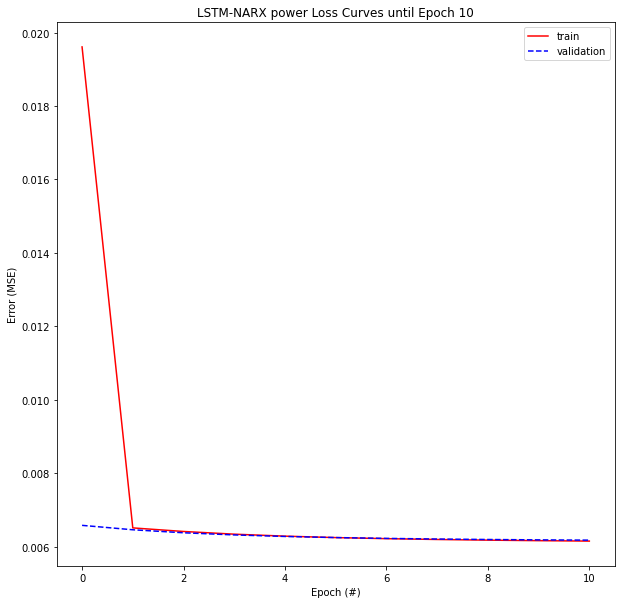

(0, 1)
Testing power....
Saving PCA Estimates in file /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/PCA_Normalized_power_01_estimates.pt
Avg RMSE for Normalized Principal Components, power: 0.07752123440649558


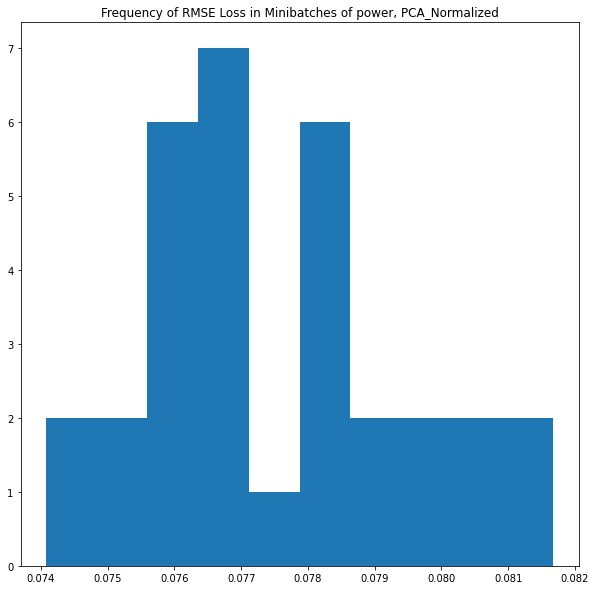

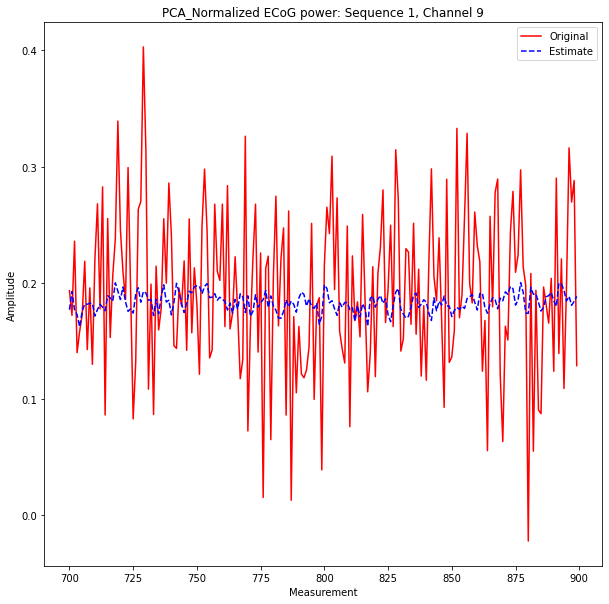

Obtained following data locations:
['/content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/PCA_Normalized_power_01_estimates.pt', '/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_ecog_01/power_dir/reduced_ECoG_Norm_01_power_test.pt', '/content/gdrive/MyDrive/BCI_Project/Datasets/checkpoint3/normalized_ecog_01/power_dir/ECoG_Norm_01_power_test.pt']
Encoder: Created Linear=((129, 64))
Encoder: Created Linear=((64, 32))
Encoder: Created Linear=((32, 16))
Decoder: Created Linear=((16, 32))
Decoder: Created Linear=((32, 64))
Decoder: Created Linear=((64, 129))
Avg RMSE for Demapped, Normalized power: 0.23659734646466457


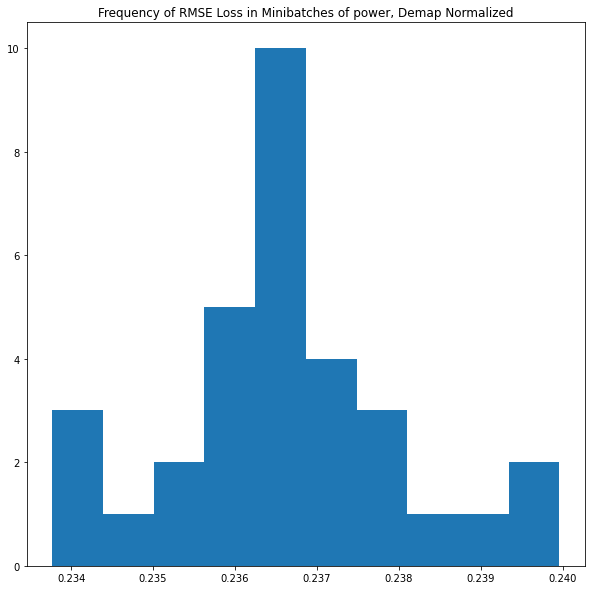

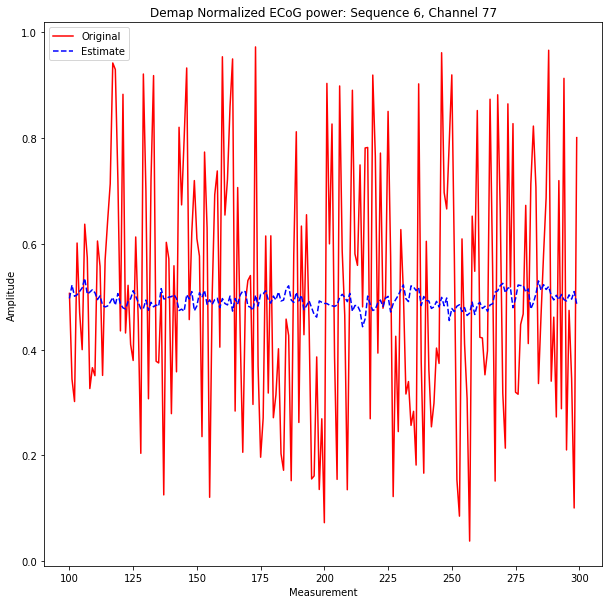

Saving Demapped Estimate /content/gdrive/MyDrive/BCI_Project/Datasets/LSTM_NARX_01/Demapped_PCA_Normalized_power_01_estimates.pt


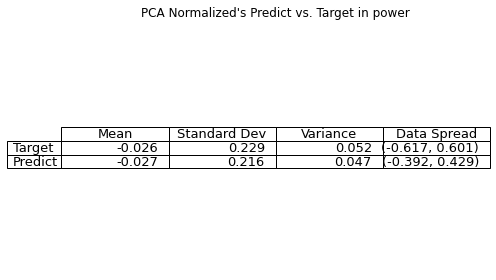

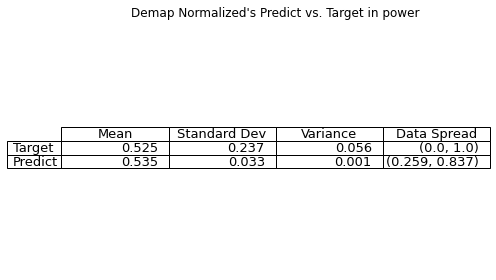

In [18]:
prediction_driver("/content/gdrive/MyDrive/BCI_Project/Datasets",10,2,[0,0,0,0],100,1e-3,specific_run=0)
normalize_demap_driver("/content/gdrive/MyDrive/BCI_Project/Datasets", [0,0,0,0], 100, specific_run = 0)